In the previous lessons, you worked with servers running locally using `stdio` transport. In this lesson, you will learn how to create a remote server using `FastMCP`, test it using MCP inspector and then learn how to deploy it on `render.com`.

You will focus on the `sse` transport. When the course was filmed, the python `sdk` for `Streamable HTTP` was in active development. However, this lesson will still give you insights into what a remote server is. We included notes for how the server implementation would be different with `Streamable HTTP` (slight changes since `FastMCP` provides you with a high-level interface).

## Creating an SSE Remote Server

With `FastMCP`, it's also easy to create an SSE remote server. You just need to specify that the transport is `sse` when running the server. You can also specify the port number when initializing the FastMCP server. The remaining tool, prompt and resource definitions are all the same. So the following code for the MCP server is the same code you saw in Lesson 7. The transport is specified at the end, and the port number of `8001` is specified in the `FastMCP` constructor (you may also decide to choose the default port as well). 

In [5]:
%%writefile mcp_project/research_server.py
import arxiv
import json
import os
from typing import List
from mcp.server.fastmcp import FastMCP

PAPER_DIR = "papers"

# Initialize FastMCP server
mcp = FastMCP("research", port=8001)

@mcp.tool()
def search_papers(topic: str, max_results: int = 5) -> List[str]:
    """
    Search for papers on arXiv based on a topic and store their information.
    
    Args:
        topic: The topic to search for
        max_results: Maximum number of results to retrieve (default: 5)
        
    Returns:
        List of paper IDs found in the search
    """
    
    # Use arxiv to find the papers 
    client = arxiv.Client()

    # Search for the most relevant articles matching the queried topic
    search = arxiv.Search(
        query = topic,
        max_results = max_results,
        sort_by = arxiv.SortCriterion.Relevance
    )

    papers = client.results(search)
    
    # Create directory for this topic
    path = os.path.join(PAPER_DIR, topic.lower().replace(" ", "_"))
    os.makedirs(path, exist_ok=True)
    
    file_path = os.path.join(path, "papers_info.json")

    # Try to load existing papers info
    try:
        with open(file_path, "r") as json_file:
            papers_info = json.load(json_file)
    except (FileNotFoundError, json.JSONDecodeError):
        papers_info = {}

    # Process each paper and add to papers_info  
    paper_ids = []
    for paper in papers:
        paper_ids.append(paper.get_short_id())
        paper_info = {
            'title': paper.title,
            'authors': [author.name for author in paper.authors],
            'summary': paper.summary,
            'pdf_url': paper.pdf_url,
            'published': str(paper.published.date())
        }
        papers_info[paper.get_short_id()] = paper_info
    
    # Save updated papers_info to json file
    with open(file_path, "w") as json_file:
        json.dump(papers_info, json_file, indent=2)
    
    print(f"Results are saved in: {file_path}")
    
    return paper_ids

@mcp.tool()
def extract_info(paper_id: str) -> str:
    """
    Search for information about a specific paper across all topic directories.
    
    Args:
        paper_id: The ID of the paper to look for
        
    Returns:
        JSON string with paper information if found, error message if not found
    """
 
    for item in os.listdir(PAPER_DIR):
        item_path = os.path.join(PAPER_DIR, item)
        if os.path.isdir(item_path):
            file_path = os.path.join(item_path, "papers_info.json")
            if os.path.isfile(file_path):
                try:
                    with open(file_path, "r") as json_file:
                        papers_info = json.load(json_file)
                        if paper_id in papers_info:
                            return json.dumps(papers_info[paper_id], indent=2)
                except (FileNotFoundError, json.JSONDecodeError) as e:
                    print(f"Error reading {file_path}: {str(e)}")
                    continue
    
    return f"There's no saved information related to paper {paper_id}."



@mcp.resource("papers://folders")
def get_available_folders() -> str:
    """
    List all available topic folders in the papers directory.
    
    This resource provides a simple list of all available topic folders.
    """
    folders = []
    
    # Get all topic directories
    if os.path.exists(PAPER_DIR):
        for topic_dir in os.listdir(PAPER_DIR):
            topic_path = os.path.join(PAPER_DIR, topic_dir)
            if os.path.isdir(topic_path):
                papers_file = os.path.join(topic_path, "papers_info.json")
                if os.path.exists(papers_file):
                    folders.append(topic_dir)
    
    # Create a simple markdown list
    content = "# Available Topics\n\n"
    if folders:
        for folder in folders:
            content += f"- {folder}\n"
        content += f"\nUse @{folder} to access papers in that topic.\n"
    else:
        content += "No topics found.\n"
    
    return content

@mcp.resource("papers://{topic}")
def get_topic_papers(topic: str) -> str:
    """
    Get detailed information about papers on a specific topic.
    
    Args:
        topic: The research topic to retrieve papers for
    """
    topic_dir = topic.lower().replace(" ", "_")
    papers_file = os.path.join(PAPER_DIR, topic_dir, "papers_info.json")
    
    if not os.path.exists(papers_file):
        return f"# No papers found for topic: {topic}\n\nTry searching for papers on this topic first."
    
    try:
        with open(papers_file, 'r') as f:
            papers_data = json.load(f)
        
        # Create markdown content with paper details
        content = f"# Papers on {topic.replace('_', ' ').title()}\n\n"
        content += f"Total papers: {len(papers_data)}\n\n"
        
        for paper_id, paper_info in papers_data.items():
            content += f"## {paper_info['title']}\n"
            content += f"- **Paper ID**: {paper_id}\n"
            content += f"- **Authors**: {', '.join(paper_info['authors'])}\n"
            content += f"- **Published**: {paper_info['published']}\n"
            content += f"- **PDF URL**: [{paper_info['pdf_url']}]({paper_info['pdf_url']})\n\n"
            content += f"### Summary\n{paper_info['summary'][:500]}...\n\n"
            content += "---\n\n"
        
        return content
    except json.JSONDecodeError:
        return f"# Error reading papers data for {topic}\n\nThe papers data file is corrupted."

@mcp.prompt()
def generate_search_prompt(topic: str, num_papers: int = 5) -> str:
    """Generate a prompt for Claude to find and discuss academic papers on a specific topic."""
    return f"""Search for {num_papers} academic papers about '{topic}' using the search_papers tool. 

    Follow these instructions:
    1. First, search for papers using search_papers(topic='{topic}', max_results={num_papers})
    2. For each paper found, extract and organize the following information:
       - Paper title
       - Authors
       - Publication date
       - Brief summary of the key findings
       - Main contributions or innovations
       - Methodologies used
       - Relevance to the topic '{topic}'
    
    3. Provide a comprehensive summary that includes:
       - Overview of the current state of research in '{topic}'
       - Common themes and trends across the papers
       - Key research gaps or areas for future investigation
       - Most impactful or influential papers in this area
    
    4. Organize your findings in a clear, structured format with headings and bullet points for easy readability.
    
    Please present both detailed information about each paper and a high-level synthesis of the research landscape in {topic}."""

if __name__ == "__main__":
    # Initialize and run the server
    mcp.run(transport='sse')

Overwriting mcp_project/research_server.py


**Streamable HTTP**: 
You can also use FastMCP to create a remote server using the transport "Streamable HTTP". The code would be again the same for tool, resource and prompt definitions. But when you run the server, you specify the transport as:

```python
mcp.run(transport="streamable-http")
```
 And when you initiate the FastMCP server you have two options:

```python
# Stateful server (maintains session state)
mcp = FastMCP("research")

# Stateless server (no session persistence)
mcp = FastMCP("research", stateless_http=True)
```

Stateless can be used when you want the server to handle simple, independent requests (no memory of previous interactions with the same client). Stateful can be used when you want the server to handle multiple requests that are part of a workflow and you want the server to remember the Client information and context across multiple requests.

## Testing the SSE Remote Server

After you create the python file for your remote server, you can test it using the MCP inspector or the simple chatbot of lesson 5, you can also integrate it with the chatbot of lesson 7. In order to test it, you first need to launch it to get its `URL` and then provide the `URL` to the chatbot or MCP inspector. 

**Note**: A server using the `stdio` transport is launched as a subprocess by the MCP client. On the other hand, a remote server is an independent processes running separately from the client and needs to be already running before the MCP client connects to it.


### How to run and test it on your local machine? - Optional Reading

You would need first to create and prepare a separate environment for the remote server. You can follow the same steps you learned about in the previous lessons:
- initiate the folder using `uv init`,
- create a virtual environment and activate it,
- add the required dependencies (`uv add arxiv mcp`).

You can then open a terminal and run your server using (`uv run research_server.py`), you'd need to keep the terminal open for the server to keep on running. You'll get a message in the terminal that the server is running at a given address. The `URL` that you would need to provide to the inspector or chatbot is that address with the appended `/sse` at the end. In a second terminal, you can launch the MCP inspector or your chatbot. Please check the comments below on how you can update the MCP chatbot. 

**Streamable HTPP**: same process for everything. For the `URL`, you would need to append `/mcp/` instead of `/sse`.

### Testing the server with MCP Inspector in this Lab

#### URL Link to the Remote server

In this lesson, you won't need to launch the remote server on your own. It's already provided to you; the remote server is already up and running in a separate container at port 8001. Run the next cell to get its URL. You'd need to use this URL to test the server in the MCP inspector. 

**Note**: If you'd like to learn how to run the MCP server in a docker container, please check the Appendix at the end of this course.

In [6]:
import os 
print("Remote server is running at:")
print(os.environ.get('DLAI_LOCAL_URL').format(port=8001)+"sse")

Remote server is running at:
https://s172-29-117-25p8001.lab-aws-production.deeplearning.ai/sse


#### Testing the Provided Remote Server using MCP Inspector

**Terminal Instructions**

- To open the terminal, run the cell below.
  - The terminal might show the `work` directory or `L4/mcp_project`. You can stay in any directory, you don't need to navigate to `L9/mcp_project`. That's because you'll test a remote server that is already up and running, so you can launch the inspector from any directory.
  - If the terminal shows `L4/mcp_project` and you still have the inspector open from L4, you can close it by typing `CTRL+C` and then launch it again.
- To launch the inspector, type in the terminal: `npx @modelcontextprotocol/inspector`
  - If you get a message asking "need to install the following packages", type: `y`
- You will get a message saying that the inspector is up and running at a specific address. To open the inspector, click on that given address. The inspector will open in another tab.
- Please check the "Inspector UI Instructions" below.
- Once you're done with the inspector UI, make sure to close the inspector by typing `Ctrl+C` in the terminal below.

**Note**: The server is running in a different environment, and there are no topics saved under papers in the server's environment, so when you check the resources in the MCP inspector, you will get that there are no resources. 

In [7]:
# start a new terminal
from IPython.display import IFrame

IFrame(f"{os.environ.get('DLAI_LOCAL_URL').format(port=8888)}terminals/1", width=600, height=768)

**Inspector UI Instructions**

In the inspector UI, make sure you have:

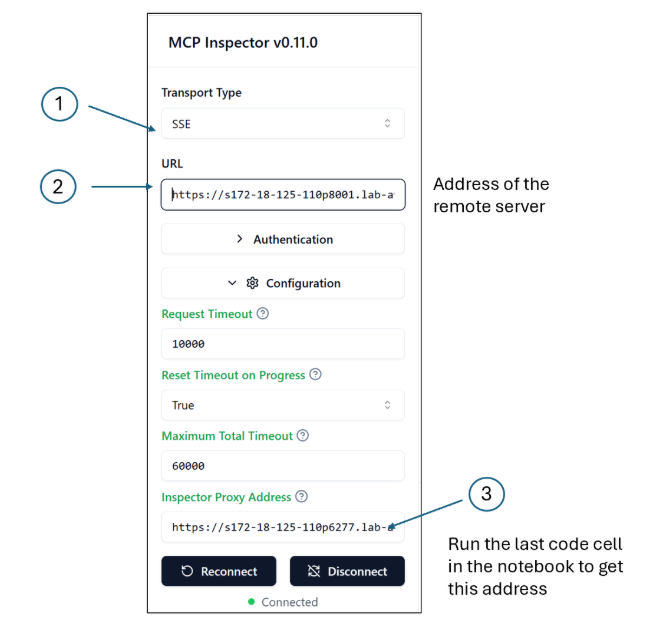

1.  `SSE` under `Transport Type`
2.  The URL of the remote server under `URL` (this is the link that ends with `sse`, the output of the cell you run before the terminal)
3.  Under configuration, you have to specify the "Inspector Proxy Address":
      - Run the following cell and copy the output address and paste it under "Inspector Proxy Address" in the inspector UI. Note: if you're running the inspector locally on your machine, you don't need to worry about this step.

In [8]:
# Print the inspector proxy address
print("Inspector Proxy Address that you need to specify under configuration in the inspector UI:")
print(os.environ.get('DLAI_LOCAL_URL').format(port=6277)[:-1])

Inspector Proxy Address that you need to specify under configuration in the inspector UI:
https://s172-29-117-25p6277.lab-aws-production.deeplearning.ai


#### Optional Note - How to Update the MCP chatbot so it can connect to a remote server?

You used `stdio_client` from the Python sdk to connect to the local server over `stdio`. The Python sdk provides another client `sse_client` that you can use to connect to a remote server over `sse`.  
First, you'd need to import `sse_client`:
```python
from mcp.client.sse import sse_client

```

Then in `connect_to_server`, you can use the same code, but instead of using `stdio_client`, you can use `sse_client` and pass to it the server url.

```python
sse_transport = await self.exit_stack.enter_async_context(
                   sse_client(url= "server_url/sse" )
                )
read, write = sse_transport 
```
The rest of the code should be the same.

**Stremable http client**

And if your remote server is running over `streamable http`, then you can similarly use the `streamablehttp_client`

``` python
from mcp.client.streamable_http import streamablehttp_client
streamable_transport = await self.exit_stack.enter_async_context(
                   streamablehttp_client(url= "server_url/mcp/" )
                )
read, write = streamable_transport 
```


## Optional - Deploying an SSE Server Using Render.com 

This part is optional and for you to explore on your local machine. If you'd like to try it, you can follow the instructions in the video. Make sure first to create an account at render [here](https://dashboard.render.com/login) using your Github account. 

## Resources

- Deploy Remote MCP servers on CloudFlare [link](https://developers.cloudflare.com/agents/guides/remote-mcp-server/)
- Streamable HTTP transport [link](https://github.com/modelcontextprotocol/python-sdk/blob/main/README.md#streamable-http-transport)
- For low level server with Streamable HTTP implementations, see:
    - Stateful server: [examples](https://github.com/modelcontextprotocol/python-sdk/tree/main/examples/servers/simple-streamablehttp)
    - Stateless server: [examples](https://github.com/modelcontextprotocol/python-sdk/tree/main/examples/servers/simple-streamablehttp-stateless)